In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import cv2
import gc


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Set global seed for reproducibility
tf.random.set_seed(42)

In [3]:
df = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/train.csv')
df.head()
df = df.sort_values("target", ascending = False)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33126 entries, 9561 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.3+ MB


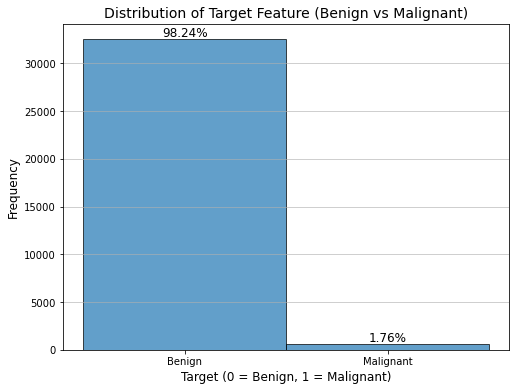

In [5]:
import matplotlib.pyplot as plt

# Plot the histogram for the target feature
plt.figure(figsize=(8, 6))
counts, bins, patches = plt.hist(df['target'], bins=2, edgecolor='black', alpha=0.7)

# Title and labels
plt.title('Distribution of Target Feature (Benign vs Malignant)', fontsize=14)
plt.xlabel('Target (0 = Benign, 1 = Malignant)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks([0.25, 0.75], ['Benign', 'Malignant'])  # Adjust x-ticks for better centering
plt.grid(axis='y', alpha=0.75)

# Calculate total number of samples
total = len(df['target'])

# Add percentages to the center of the bars
for i in range(2):
    percentage = (counts[i] / total) * 100  # Calculate percentage
    # Use (bins[i] + bins[i+1]) / 2 to find the center of the bin
    plt.text((bins[i] + bins[i+1]) / 2, counts[i], f'{percentage:.2f}%', 
             ha='center', va='bottom', fontsize=12)  # ha=center for horizontal alignment

plt.show()


In [6]:
df_1 = df.iloc[:584]
df_0 = df.iloc[584:1440]
df_0 = df_0.sample(frac = 1)
df_0.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
22066,ISIC_6681628,IP_6118207,male,45.0,lower extremity,unknown,benign,0
22309,ISIC_6761105,IP_0915233,male,65.0,lower extremity,unknown,benign,0
22446,ISIC_6801892,IP_1582457,male,50.0,torso,unknown,benign,0
21964,ISIC_6649866,IP_8702124,female,50.0,lower extremity,unknown,benign,0
21929,ISIC_6638869,IP_1173567,male,70.0,torso,unknown,benign,0


In [7]:
df_train = pd.concat([df_1,df_0])
df_train = df_train.sample(frac=1)
df_train

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
22304,ISIC_6760032,IP_9122609,male,65.0,torso,unknown,benign,0
26954,ISIC_8167374,IP_8361815,male,80.0,torso,melanoma,malignant,1
5045,ISIC_1616031,IP_0690987,male,50.0,torso,melanoma,malignant,1
22374,ISIC_6781528,IP_5533537,female,50.0,lower extremity,unknown,benign,0
22417,ISIC_6791989,IP_6997528,female,35.0,torso,unknown,benign,0
...,...,...,...,...,...,...,...,...
22685,ISIC_6885717,IP_7842431,male,40.0,torso,unknown,benign,0
22225,ISIC_6731651,IP_3008149,male,65.0,torso,unknown,benign,0
21157,ISIC_6422791,IP_8598620,female,70.0,head/neck,unknown,benign,0
22232,ISIC_6734679,IP_1454551,female,45.0,torso,nevus,benign,0


In [8]:
def preprocessing(dataset):
    # Impute missing values using mode for the specified columns
    sex_mode = dataset['sex'].mode()[0]
    age_approx_mode = dataset['age_approx'].mode()[0]
    anatom_site_mode = dataset['anatom_site_general_challenge'].mode()[0]

    dataset['sex'].fillna(sex_mode, inplace=True)
    dataset['age_approx'].fillna(age_approx_mode, inplace=True)
    dataset['anatom_site_general_challenge'].fillna(anatom_site_mode, inplace=True)

    # Replace categorical values with integers in a logical order
    dataset = dataset.replace(to_replace=['male'], value=0)
    dataset = dataset.replace(to_replace=['female'], value=1)
    
    dataset = dataset.replace(to_replace=['torso'], value=0)
    dataset = dataset.replace(to_replace=['lower extremity'], value=1)
    dataset = dataset.replace(to_replace=['upper extremity'], value=2)
    dataset = dataset.replace(to_replace=['head/neck'], value=3)
    dataset = dataset.replace(to_replace=['palms/soles'], value=4)  # Changed from 5 to 4 for logical order
    dataset = dataset.replace(to_replace=['oral/genital'], value=5)  # Changed from 6 to 5 for logical order
    
    return dataset



In [9]:
df_train = preprocessing(df_train)
df_train

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
22304,ISIC_6760032,IP_9122609,0,65.0,0,unknown,benign,0
26954,ISIC_8167374,IP_8361815,0,80.0,0,melanoma,malignant,1
5045,ISIC_1616031,IP_0690987,0,50.0,0,melanoma,malignant,1
22374,ISIC_6781528,IP_5533537,1,50.0,1,unknown,benign,0
22417,ISIC_6791989,IP_6997528,1,35.0,0,unknown,benign,0
...,...,...,...,...,...,...,...,...
22685,ISIC_6885717,IP_7842431,0,40.0,0,unknown,benign,0
22225,ISIC_6731651,IP_3008149,0,65.0,0,unknown,benign,0
21157,ISIC_6422791,IP_8598620,1,70.0,3,unknown,benign,0
22232,ISIC_6734679,IP_1454551,1,45.0,0,nevus,benign,0


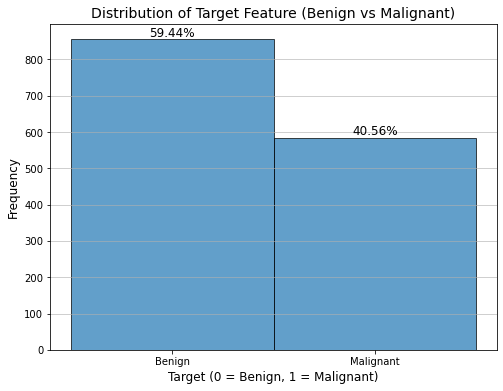

In [10]:
import matplotlib.pyplot as plt

# Plot the histogram for the target feature
plt.figure(figsize=(8, 6))
counts, bins, patches = plt.hist(df_train['target'], bins=2, edgecolor='black', alpha=0.7)

# Title and labels
plt.title('Distribution of Target Feature (Benign vs Malignant)', fontsize=14)
plt.xlabel('Target (0 = Benign, 1 = Malignant)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks([0.25, 0.75], ['Benign', 'Malignant'])  # Adjust x-ticks for better centering
plt.grid(axis='y', alpha=0.75)

# Calculate total number of samples in df_train
total = len(df_train['target'])

# Add percentages to the center of the bars
for i in range(2):
    percentage = (counts[i] / total) * 100  # Calculate percentage based on df_train
    # Use (bins[i] + bins[i+1]) / 2 to find the center of the bin
    plt.text((bins[i] + bins[i+1]) / 2, counts[i], f'{percentage:.2f}%', 
             ha='center', va='bottom', fontsize=12)  # ha=center for horizontal alignment

plt.show()


In [11]:
df_test = preprocessing(pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/test.csv'))
df_test

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,0,70.0,0
1,ISIC_0052349,IP_7782715,0,40.0,1
2,ISIC_0058510,IP_7960270,1,55.0,0
3,ISIC_0073313,IP_6375035,1,50.0,0
4,ISIC_0073502,IP_0589375,1,45.0,1
...,...,...,...,...,...
10977,ISIC_9992485,IP_4152479,0,40.0,0
10978,ISIC_9996992,IP_4890115,0,35.0,0
10979,ISIC_9997917,IP_2852390,0,25.0,2
10980,ISIC_9998234,IP_8861963,0,65.0,1


In [12]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if (isinstance(value, type(tf.constant(0)))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


In [13]:
def image_example(image_string, sex, age_approx,anatom_site_general_challenge, target, isTrain, image_name):

    if (isTrain):
        feature = {
            'sex': _int64_feature(sex),
            'age_approx': _float_feature(age_approx),
            'anatom_site_general_challenge': _int64_feature(anatom_site_general_challenge),
            'target': _int64_feature(target),
            'image_raw': _bytes_feature(image_string),
            }
    else:
        feature = {
            'image_name': _bytes_feature(image_name),
            'sex': _int64_feature(sex),
            'age_approx': _float_feature(age_approx),
            'anatom_site_general_challenge': _int64_feature(anatom_site_general_challenge),
            'image_raw': _bytes_feature(image_string),
            }
        
    return tf.train.Example(features=tf.train.Features(feature=feature))


In [14]:
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# Step 1: Split the data into training and validation sets
train_df, valid_df = train_test_split(df_train, test_size=0.2, random_state=42, stratify=df_train['target'])

# Step 2: Oversample the training data to balance the target classes (target == 1 and target == 0)
def oversample_training_data(train_df):
    # Separate features and target
    X_train = train_df.drop(columns=['target'])
    y_train = train_df['target']
    
    # Initialize the RandomOverSampler
    ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
    
    # Fit and resample the training data to balance the classes
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
    
    # Combine the oversampled features and target back into a DataFrame
    train_df_resampled = X_train_resampled.copy()
    train_df_resampled['target'] = y_train_resampled
    
    return train_df_resampled

# Oversample the training data
train_df_oversampled = oversample_training_data(train_df)

# Step 3: Function to write the TFRecord files
def write_tfrecord(df, record_file):
    with tf.io.TFRecordWriter(record_file) as writer:
        for row in df.iterrows():
            # Read and process image
            im = cv2.imread('/kaggle/input/siim-isic-melanoma-classification/jpeg/train/' + row[1]['image_name'] + '.jpg')
            im_resize = cv2.resize(im, (300, 300))
            is_success, im_buf_arr = cv2.imencode(".jpg", im_resize)
            image_string = im_buf_arr.tobytes()

            # Create the example
            tf_example = image_example(image_string, row[1]['sex'], row[1]['age_approx'], 
                                       row[1]['anatom_site_general_challenge'], row[1]['target'], 
                                       isTrain=True, image_name=None)
            
            # Write the example to the TFRecord file
            writer.write(tf_example.SerializeToString())

# File paths for training and validation TFRecord files
train_record_file = '/kaggle/working/train.tfrecords'
valid_record_file = '/kaggle/working/valid.tfrecords'

# Step 4: Write the oversampled training data to a TFRecord file
write_tfrecord(train_df_oversampled, train_record_file)

# Step 5: Write the validation data to a separate TFRecord file (no oversampling for validation)
write_tfrecord(valid_df, valid_record_file)

print("TFRecords for oversampled training and validation have been saved.")


Using TensorFlow backend.


TFRecords for oversampled training and validation have been saved.


In [15]:
# record_file = '/kaggle/working/test.tfrecords'
# with tf.io.TFRecordWriter(record_file) as writer:
#     for row in df_test.iterrows():
# #         image_string = open('/kaggle/input/siim-isic-melanoma-classification/jpeg/train/' + row[1]['image_name'] + '.jpg', 'rb').read()
#         im_test = cv2.imread('/kaggle/input/siim-isic-melanoma-classification/jpeg/test/' + row[1]['image_name'] + '.jpg')
#         im_resize = cv2.resize(im_test, (256, 256))
#         is_success, im_buf_arr = cv2.imencode(".jpg", im_resize)
#         image_string = im_buf_arr.tobytes()
#         tf_example = image_example(image_string,row[1]['sex'], row[1]['age_approx'],row[1]['anatom_site_general_challenge'], None, isTrain = False,image_name = bytes(row[1]['image_name'], 'utf-8'))
#         writer.write(tf_example.SerializeToString())

In [16]:
BATCH_SIZE = 16
SHUFFLE_SIZE = 1440
STEPS_PER_EPOCH = int(len(df_train.index)/BATCH_SIZE)

In [17]:
def _parse_function_train(proto):
    # define your tfrecord again. Remember that you saved your image as a string.
    keys_to_features = {'image_raw': tf.io.FixedLenFeature([], tf.string),
                        'target': tf.io.FixedLenFeature([], tf.int64),
                        'sex': tf.io.FixedLenFeature([], tf.int64),
                        'age_approx': tf.io.FixedLenFeature([], tf.float32),
                       'anatom_site_general_challenge': tf.io.FixedLenFeature([],tf.int64)}
    
    # Load one example
    parsed_features = tf.io.parse_single_example(proto, keys_to_features)
    
    image_shape = tf.stack([300,300,3])
#     target_shape = tf.stack([1])
    
    # Turn your saved image string into an array
    parsed_features['image_raw'] = tf.io.decode_jpeg(parsed_features['image_raw'], 3)#, fixed_length = 256*256*3)
    
#     parsed_features['image'] = tf.cast(parsed_features['image']/255, tf.float32)

    
    parsed_features['image_raw'] = tf.reshape(parsed_features['image_raw'], image_shape)
    
    parsed_features['image_raw'] = tf.image.random_brightness(parsed_features['image_raw'],0.35)
    
    parsed_features['image_raw'] = tf.image.random_contrast(parsed_features['image_raw'],0.1,0.36)
    
    parsed_features['image_raw'] = tf.image.random_flip_left_right(parsed_features['image_raw'])
    
    parsed_features['image_raw'] = tf.image.random_flip_up_down(parsed_features['image_raw'])
    
    
#     parsed_features["target"] = tf.reshape(parsed_features['target'],target_shape)
    
    return parsed_features['image_raw'], parsed_features['sex'], parsed_features['age_approx'], parsed_features['anatom_site_general_challenge'],parsed_features['target']

In [18]:
def dataset_fetch (filenames, isTrain):
    
    dataset = tf.data.TFRecordDataset(filenames)
    
    dataset = dataset.repeat()

    if(isTrain):
        dataset = dataset.map(_parse_function_train)

#     else:
#         dataset = dataset.map(_parse_function_test)
        
    dataset = dataset.shuffle(SHUFFLE_SIZE,seed=42)

    dataset = dataset.batch(BATCH_SIZE)
        
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
            
    return dataset

In [19]:
# from PIL import Image
training_dataset = dataset_fetch('/kaggle/working/train.tfrecords',True)
# training_dataset = training_dataset.repeat(-1)
training_dataset


<PrefetchDataset shapes: ((None, 300, 300, 3), (None,), (None,), (None,), (None,)), types: (tf.uint8, tf.int64, tf.float32, tf.int64, tf.int64)>

In [20]:
# from PIL import Image
validation_dataset = dataset_fetch('/kaggle/working/valid.tfrecords',True)

validation_dataset


<PrefetchDataset shapes: ((None, 300, 300, 3), (None,), (None,), (None,), (None,)), types: (tf.uint8, tf.int64, tf.float32, tf.int64, tf.int64)>

In [21]:
def fetch_data(iterator):
#     image,sex,age,site,target = iterator.get_next()
    while True:
        image,sex,age,site,target = iterator.get_next()
        yield ([image,sex,age,site],target)

In [22]:
iterator = iter(training_dataset)
training_dataset_final = fetch_data(iterator)

print(training_dataset_final)

<generator object fetch_data at 0x7fe3dc76cc50>


In [23]:
iterator = iter(validation_dataset)
validation_dataset_final = fetch_data(iterator)

print(validation_dataset_final)

<generator object fetch_data at 0x7fe3dc76cf50>


In [24]:
image_input = tf.keras.layers.Input(shape = (300,300,3))
x1 = tf.keras.applications.Xception(weights = 'imagenet', include_top = False)(image_input)
x1 = tf.keras.layers.MaxPooling2D((2,2))(x1)
x1 = tf.keras.layers.Flatten()(x1)
x1 = tf.keras.layers.Dense(128, activation = 'relu')(x1)
x1 = tf.keras.layers.Dropout(0.2)(x1)
# x1 = tf.keras.layers.Dense(128, activation = 'relu')(x1)
# x1 = tf.keras.layers.Dropout(0.2)(x1)
out1 = tf.keras.layers.Dense(32, activation = 'relu',kernel_regularizer = tf.keras.regularizers.l2())(x1)


age_input = tf.keras.layers.Input(shape = (1))
# x2 = tf.keras.layers.Dense(128,activation = 'relu')(age_input)
x2 = tf.keras.layers.Dense(64, activation = 'relu')(age_input)
x2 = tf.keras.layers.Dropout(0.2)(x2)
out2 = tf.keras.layers.Dense(32, activation = 'relu',kernel_regularizer = tf.keras.regularizers.l2())(x2)

gender_input = tf.keras.layers.Input(shape = (1))
# x3 = tf.keras.layers.Dense(128,activation = 'relu')(gender_input)
x3 = tf.keras.layers.Dense(64, activation = 'relu')(gender_input)
x3 = tf.keras.layers.Dropout(0.2)(x3)
out3 = tf.keras.layers.Dense(32, activation = 'relu',kernel_regularizer = tf.keras.regularizers.l2())(x3)

site_input = tf.keras.layers.Input(shape = (1))
# x4 = tf.keras.layers.Dense(128,activation = 'relu')(site_input)
x4 = tf.keras.layers.Dense(64, activation = 'relu')(site_input)
x4 = tf.keras.layers.Dropout(0.2)(x4)
out4 = tf.keras.layers.Dense(32, activation = 'relu',kernel_regularizer = tf.keras.regularizers.l2())(x4)

merge1 = tf.keras.layers.concatenate([out1,out3,out2,out4])

op = tf.keras.layers.Dense(64, activation = 'relu')(merge1)
op = tf.keras.layers.Dropout(0.3)(op)
# op = tf.keras.layers.Dense(64, activation = 'relu')(op)
op = tf.keras.layers.Dense(16, activation = 'relu',kernel_regularizer = tf.keras.regularizers.l2())(op)
output_final = tf.keras.layers.Dense(1, activation = 'sigmoid')(op)

model = tf.keras.models.Model(inputs = [image_input,gender_input,age_input, site_input], outputs = output_final)


83689472/83683744 [==============================] - 1s 0us/step


In [25]:
model.compile( optimizer=tf.keras.optimizers.Adamax(),
    loss='binary_crossentropy',
    metrics=['accuracy'],)
#     target_tensors = [image_raw])

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
xception (Model)                multiple             20861480    input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 5, 5, 2048)   0           xception[1][0]                   
__________________________________________________________________________________________________
flatten (Flatten)               (None, 51200)        0           max_pooling2d[0][0]              
______________________________________________________________________________________________

In [27]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Step 1: Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',    # Monitoring validation accuracy for stopping
    patience=10,                # Stop if there's no improvement for 5 epochs
    restore_best_weights=True, # Restore best model weights
    verbose=1                  # Display message when stopping
)

In [28]:
# model.fit(training_dataset_final,
#           epochs = 2,
#          steps_per_epoch = STEPS_PER_EPOCH)

# Step 2: Fit the model with EarlyStopping callback
history = model.fit(
    training_dataset_final,
    validation_data=validation_dataset_final,
    epochs=50,  # Max epochs (training will stop early if no improvement)
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=len(valid_df) // BATCH_SIZE,
    callbacks=[early_stopping]  # Add the EarlyStopping callback here
)

Epoch 1/50
90/90 [==============================] - 39s 438ms/step - loss: 2.2647 - accuracy: 0.6451 - val_loss: 1.9512 - val_accuracy: 0.6215
Epoch 2/50
90/90 [==============================] - 34s 380ms/step - loss: 1.5621 - accuracy: 0.7139 - val_loss: 1.4199 - val_accuracy: 0.7361
Epoch 3/50
90/90 [==============================] - 34s 379ms/step - loss: 1.2744 - accuracy: 0.7431 - val_loss: 1.2776 - val_accuracy: 0.7535
Epoch 4/50
90/90 [==============================] - 34s 378ms/step - loss: 1.1460 - accuracy: 0.7812 - val_loss: 1.2260 - val_accuracy: 0.7535
Epoch 5/50
90/90 [==============================] - 34s 379ms/step - loss: 0.9925 - accuracy: 0.8292 - val_loss: 1.0818 - val_accuracy: 0.8056
Epoch 6/50
90/90 [==============================] - 34s 378ms/step - loss: 0.9428 - accuracy: 0.8403 - val_loss: 1.0240 - val_accuracy: 0.7500
Epoch 7/50
90/90 [==============================] - 34s 379ms/step - loss: 0.8755 - accuracy: 0.8431 - val_loss: 0.9608 - val_accuracy: 0.8160

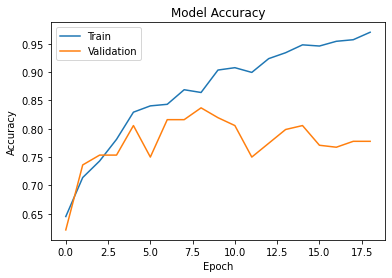

In [29]:
# Step 3: Plot training & validation accuracy values
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Plot accuracy
plot_accuracy(history)

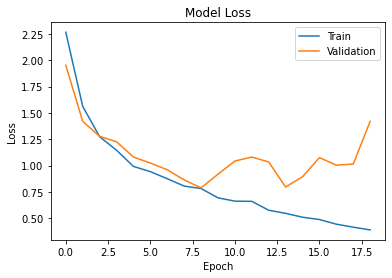

In [30]:
# Step 4: Plot training & validation loss values
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

# Plot loss
plot_loss(history)

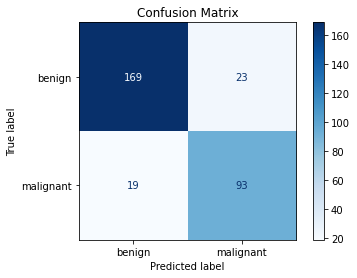

In [31]:
# Initialize lists to store true labels and predictions
y_true = []
y_pred = []

# Define your custom threshold (e.g., 0.7)
custom_threshold = 0.40

# Iterate through the validation dataset generator to get predictions
for step, (x, y) in enumerate(validation_dataset_final):
    predictions = model.predict(x)  # Get model predictions
    
    # Apply custom threshold instead of rounding
    y_true.extend(y)  # Ground truth labels
    y_pred.extend((predictions >= custom_threshold).astype(int).flatten())  # Apply threshold
    
    # Optional: Stop after a certain number of steps if necessary
    if step >= len(valid_df) // BATCH_SIZE:
        break

# Convert lists to arrays for confusion matrix generation
y_true = np.array(y_true).astype(int)
y_pred = np.array(y_pred).astype(int)

# Step 5: Generate and display confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['benign', 'malignant'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()



In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import pandas as pd

# Calculate precision, recall, f1-score, and accuracy
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

# Create a pandas DataFrame to display the metrics
metrics_data = {
    'Metric': ['Precision', 'Recall', 'F1 Score', 'Accuracy'],
    'Score': [precision, recall, f1, accuracy]
}

metrics_df = pd.DataFrame(metrics_data)

# Display the DataFrame using Pandas
print(metrics_df)


      Metric     Score
0  Precision  0.801724
1     Recall  0.830357
2   F1 Score  0.815789
3   Accuracy  0.861842


In [33]:
from IPython.display import display
display(metrics_df)


,Metric,Score
0,Precision,0.801724
1,Recall,0.830357
2,F1 Score,0.815789
3,Accuracy,0.861842


In [34]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=['benign', 'malignant'])

# Print the classification report
print(report)


              precision    recall  f1-score   support

      benign       0.90      0.88      0.89       192
   malignant       0.80      0.83      0.82       112

    accuracy                           0.86       304
   macro avg       0.85      0.86      0.85       304
weighted avg       0.86      0.86      0.86       304



In [35]:
gc.collect()

8363

In [36]:
predictions_list = np.array([], dtype = 'float32')
print(predictions_list)
for row in df_test.iterrows():
    im_test = cv2.imread('/kaggle/input/siim-isic-melanoma-classification/jpeg/test/' + row[1]['image_name'] + '.jpg')
    im_resize = np.reshape(cv2.resize(im_test, (300, 300)), (1,300,300,3))
    predictions_list = np.append(predictions_list,model.predict([im_resize, np.reshape(row[1]['sex'],(1)), 
                                                                                np.reshape(row[1]['age_approx'],(1)), 
                                                                                    np.reshape(row[1]['anatom_site_general_challenge'],(1))])[0])#[1])

    print(predictions_list.shape, end = "\r")


[]


In [37]:
gc.collect()

16097

In [38]:
unique_elements, counts_elements = np.unique(predictions_list, return_counts=True)

print(np.asarray((unique_elements, counts_elements)))

[[1.15633736e-06 2.56644603e-06 3.44692080e-06 ... 9.97748077e-01
  9.97749031e-01 9.98923719e-01]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]]


In [39]:
test_image_name = df_test['image_name'].to_numpy()

In [40]:
sample_submission = pd.DataFrame({"image_name":test_image_name, "target":predictions_list})
sample_submission

,image_name,target
0,ISIC_0052060,0.007451
1,ISIC_0052349,0.008238
2,ISIC_0058510,0.067973
3,ISIC_0073313,0.000049
4,ISIC_0073502,0.154718
...,...,...
10977,ISIC_9992485,0.655941
10978,ISIC_9996992,0.927565
10979,ISIC_9997917,0.797874
10980,ISIC_9998234,0.000630


In [41]:
sample_submission.to_csv("submission.csv",index = False)

In [42]:
# Save the entire model
model.save('/kaggle/working/model_with_splitting_1.h5')  # Save the model as an HDF5 file (or you can specify other file paths)

print("Model saved successfully!")


Model saved successfully!
